In [31]:
# Check GPU availability (should show at least one GPU if you've enabled GPU runtime)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)
if not gpus:
    print("Warning: No GPU found. Make sure you've enabled GPU in Runtime > Change runtime type > GPU.")


TensorFlow version: 2.19.0
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
# Install kaggle (only needed in Colab) and other dependencies
!pip install -q kaggle
!pip install -q matplotlib


In [33]:
# Upload kaggle.json (Kaggle API token).
from google.colab import files
print("Please upload your kaggle.json (Kaggle API token). If you already uploaded earlier in this session, skip.")
uploaded = files.upload()
# The above will show uploader. After uploading, the file will be in the working directory.


Please upload your kaggle.json (Kaggle API token). If you already uploaded earlier in this session, skip.


Saving kaggle.json to kaggle.json


In [34]:
# Move kaggle.json to ~/.kaggle and set permissions
import os, shutil
if os.path.exists('kaggle.json'):
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    print("kaggle.json moved to ~/.kaggle/")
else:
    print("kaggle.json not found. If you uploaded it previously, you can ignore this message.")


kaggle.json moved to ~/.kaggle/


In [35]:
!kaggle datasets list -s face | head -n 20


ref                                                    title                                            size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ----------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
andrewmvd/face-mask-detection                          Face Mask Detection                         416968083  2020-05-22 07:18:42.220000         105282       1913  0.875            
splcher/animefacedataset                               Anime Face Dataset                          413825766  2019-10-13 16:33:20.520000          44951        464  0.9375           
atulanandjha/lfwpeople                                 LFW - People (Face Recognition)             243503888  2019-11-15 19:45:43.120000          51074        498  1.0              
dataturks/face-detection-in-images                     Face Detection in Images           

In [36]:
dataset_slug = "omkargurav/face-mask-dataset"

In [37]:
# Download a popular face mask dataset from Kaggle.
# download, unzip into /content and list top files
!kaggle datasets download -d omkargurav/face-mask-dataset -p /content --unzip
!ls -lah /content | sed -n '1,200p'


Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 88% 143M/163M [00:00<00:00, 1.49GB/s]
100% 163M/163M [00:00<00:00, 1.42GB/s]
total 50M
drwxr-xr-x 1 root root 4.0K Nov  8 19:53 .
drwxr-xr-x 1 root root 4.0K Nov  8 18:15 ..
drwxr-xr-x 4 root root 4.0K Nov  5 14:33 .config
drwxr-xr-x 4 root root 4.0K Nov  8 18:38 data
-rw-r--r-- 1 root root  50M Nov  8 18:56 face_mask_detector.h5
-rw-r--r-- 1 root root 7.2K Nov  8 19:00 faceWithMask (1).jpeg
-rw-r--r-- 1 root root 7.2K Nov  8 19:52 faceWithMask (2).jpeg
-rw-r--r-- 1 root root 7.2K Nov  8 19:00 faceWithMask.jpeg
-rw-r--r-- 1 root root 4.9K Nov  8 19:00 faceWithoutMask2.jpeg
-rw-r--r-- 1 root root  11K Nov  8 19:01 faceWithoutMask.jpeg
-rw-r--r-- 1 root root 7.3K Nov  8 19:01 facwWithBothMask and NotMask.jpeg
drwxr-xr-x 2 root root 4.0K Nov  8 19:20 .ipynb_checkpoints
drwxr-xr-x 1 root root 4.0K Nov  5 14:33 sample_data


In [38]:
# Inspect dataset structure (list top-level files/directories)
import os
for root, dirs, files in os.walk(".", topdown=True):
    if root.count(os.sep) > 2:  # limit output depth
        continue
    print(root, "->", len(files), "files,", len(dirs), "dirs")


. -> 7 files, 4 dirs
./.config -> 8 files, 2 dirs
./.config/logs -> 0 files, 1 dirs
./.config/configurations -> 1 files, 0 dirs
./data -> 0 files, 2 dirs
./data/without_mask -> 3828 files, 0 dirs
./data/with_mask -> 3725 files, 0 dirs
./.ipynb_checkpoints -> 0 files, 0 dirs
./sample_data -> 6 files, 0 dirs


In [39]:
# Many Kaggle face mask datasets include directories like 'train'/'test' or 'Dataset' with 'with_mask'/'without_mask'.
# We'll try common locations. If not found, adjust `data_dir` to point to your images.
possible_paths = [
    "Dataset",
    "face-mask-dataset",
    "Face Mask Dataset",
    "Face-Mask-Detection",
    "face-mask-dataset/Train",
    "Face Mask Dataset/Train",
    "train"
]
data_dir = None
for p in possible_paths:
    if os.path.exists(p):
        data_dir = p
        break

# If dataset directory not detected at those names, search for any dirs containing 'mask' or 'with_mask'
if data_dir is None:
    for d in os.listdir("."):
        if os.path.isdir(d) and "mask" in d.lower():
            data_dir = d
            break

if data_dir is None:
    print("Could not auto-detect dataset directory. Please set `data_dir` manually to the folder with 'with_mask' and 'without_mask' subfolders.")
else:
    print("Using data_dir =", data_dir)
    print("Contents:", os.listdir(data_dir)[:20])


Could not auto-detect dataset directory. Please set `data_dir` manually to the folder with 'with_mask' and 'without_mask' subfolders.


In [42]:


assert data_dir is not None, "Set data_dir to the folder containing class subfolders (with_mask, without_mask)."


In [41]:
data_dir = "/content/data"

In [43]:
# We'll use Keras ImageDataGenerator with a validation split.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

IMG_SIZE = (128, 128)        # small for fast training; increase if you want higher accuracy
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,   # 20% validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   # two classes: with_mask / without_mask
    subset='training',
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

num_train = train_gen.samples
num_val = val_gen.samples
steps_per_epoch = math.ceil(num_train / BATCH_SIZE)
validation_steps = math.ceil(num_val / BATCH_SIZE)

print(f"Train samples: {num_train}, Val samples: {num_val}")
print("Class indices:", train_gen.class_indices)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Train samples: 6043, Val samples: 1510
Class indices: {'with_mask': 0, 'without_mask': 1}


In [44]:
# Build a simple CNN model .
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_model(input_shape=IMG_SIZE + (3,)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # binary classification
    ])
    return model

model = build_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,217 (16.36 MB)

 Trainable params: 4,288,513 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [45]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [46]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps
)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 50s 232ms/step - accuracy: 0.8124 - loss: 0.5161 - val_accuracy: 0.5073 - val_loss: 2.1190
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 204ms/step - accuracy: 0.8958 - loss: 0.2767 - val_accuracy: 0.6258 - val_loss: 1.0611
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9037 - loss: 0.2401 - val_accuracy: 0.9331 - val_loss: 0.1766
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 203ms/step - accuracy: 0.9224 - loss: 0.2016 - val_accuracy: 0.8755 - val_loss: 0.3397
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 203ms/step - accuracy: 0.9160 - loss: 0.2030 - val_accuracy: 0.9245 - val_loss: 0.1991
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.9398 - loss: 0.1568 - val_accuracy: 0.8272 - val_loss: 0.4998
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 203ms/step - accuracy: 0.9481 - loss: 0.1353 - val_accuracy: 0.9377 - val_loss: 0.1527
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.9480 - loss: 0

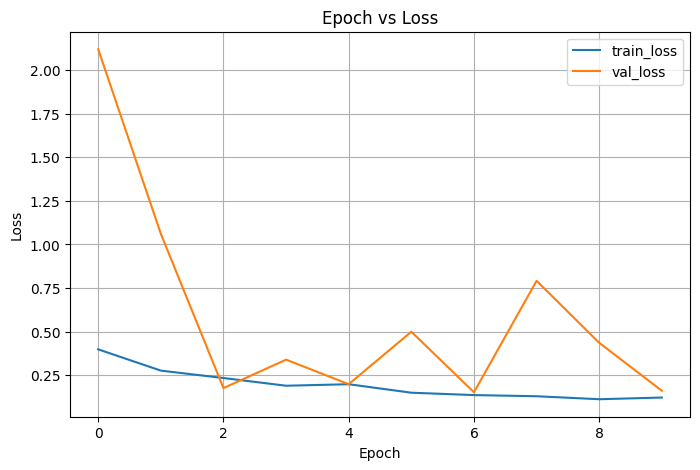

In [47]:
# Plot epoch vs loss (training and validation)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Print training and validation accuracy (final epoch)
train_acc = history.history.get('accuracy')[-1]
val_acc = history.history.get('val_accuracy')[-1]
print(f"Final training accuracy: {train_acc*100:.2f}%")
print(f"Final validation accuracy: {val_acc*100:.2f}%")


Final training accuracy: 95.30%
Final validation accuracy: 93.64%


In [49]:
# Save the model for future use
model_save_path = "face_mask_detector.h5"
model.save(model_save_path)
print("Model saved to", model_save_path)


Model saved to face_mask_detector.h5


Please upload an image to classify (one image file).


Saving faceWithMask.jpeg to faceWithMask (3).jpeg
Uploaded file: faceWithMask (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


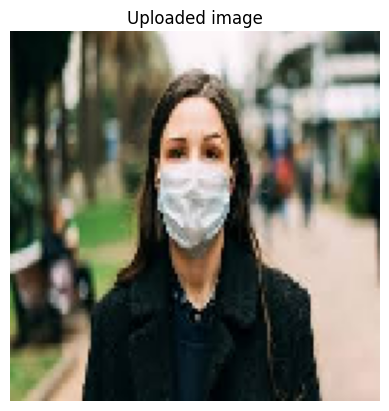

Model output (sigmoid) = 0.0137
Predicted: with_mask with confidence 98.63%
Class indices mapping (from training): {'with_mask': 0, 'without_mask': 1}


In [50]:
# Prompt user to upload an image for classification
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

print("Please upload an image to classify (one image file).")
uploaded = files.upload()
if not uploaded:
    print("No file uploaded.")
else:
    # Take first uploaded file
    img_path = next(iter(uploaded.keys()))
    print("Uploaded file:", img_path)

    # Preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    x = np.expand_dims(img_array, axis=0)  # shape (1, H, W, 3)

    # Predict
    prob = model.predict(x)[0][0]
    # If class indices map: e.g., {'with_mask': 0, 'without_mask': 1} or vice versa.
    # We'll inspect train_gen.class_indices to map properly.
    class_indices = train_gen.class_indices
    # invert
    inv_map = {v:k for k,v in class_indices.items()}
    # Determine label
    label_index = int(round(prob))  # 0 or 1 after rounding
    label_prob = prob if class_indices.get('without_mask', None)==1 else prob  # keep numeric prob; we'll interpret below

    # Interpret: since model outputs sigmoid(probability of class '1')
    # Find which class corresponds to index 1
    label_for_one = inv_map.get(1, "class_1")
    label_for_zero = inv_map.get(0, "class_0")

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded image")
    plt.show()

    # Show probability & predicted label (more informative)
    print(f"Model output (sigmoid) = {prob:.4f}")
    if prob >= 0.5:
        predicted_label = label_for_one
        confidence = prob
    else:
        predicted_label = label_for_zero
        confidence = 1 - prob
    print(f"Predicted: {predicted_label} with confidence {confidence*100:.2f}%")
    print("Class indices mapping (from training):", class_indices)
